- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack


from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.layers import Conv1D,GRU,TimeDistributed,MaxPooling1D,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling1D,ZeroPadding1D

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features=scaler.fit_transform(df_features)

# Select k-best features

In [5]:
#from sklearn.feature_selection import SelectKBest,f_classif
#k=[12,15,18,21,24,31]
df_features = SelectKBest(f_classif,k=12).fit_transform(df_features,mind_wandered_label)

In [6]:
participant_ids=participant_ids[:2193]

# Allknn undersampling

In [7]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN()
df_features, mind_wandered_label = allknn.fit_resample(df_features, mind_wandered_label)

# SMOTEENN Oversampling

In [8]:
"""from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
df_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)"""

'from imblearn.combine import SMOTEENN\nsme = SMOTEENN(random_state=42)\ndf_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)'

In [9]:
mind_wandered_label.shape

(2193,)

# Data Reshape for conv1d

In [10]:
#df_features = df_features.to_numpy()
df_features=df_features.reshape((df_features.shape[0], df_features.shape[1], 1))
df_features.shape

(2193, 12, 1)

# AUROC

In [11]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

# Conv1d Model

In [12]:
def create_model(units=16):
    model = Sequential([
    LSTM(units, recurrent_dropout=0.1,return_sequences=True,activation='tanh',input_shape=(df_features.shape[1], 1)),
    LSTM(units,recurrent_dropout=0.1),
    #ZeroPadding1D(padding=1),
    #Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
    optimizer=SGD(lr=0.001)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', auc_roc])
    return model

In [13]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=50, batch_size=32, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [14]:

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None


parameters = {
        #'scaling__type_of_scaling': ['standard'],
        #'outlier__outlier_threshold': [0.0, 3.0],
        #'features__k': [12,15],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        'model__batch_size': [32, 48],#usually multiple of 8
        'model__epochs':[50,60],
        'model__units':[8,16,32,64],
        #'model__kernel_size':[3,5,7],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

# Estimator Pipeline
pipeline = Pipeline(
      [
        #('progress', GridSearchProgressHack(verbose=False)),
        #('scaling',  FeatureScalerTransformer()),
        #('outlier',  WinsorizationOutlierTransformer()),
        #('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        #('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
# Cross Validation Splitter
cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        #cv = 5,
        refit = 'roc_auc',
        verbose = 1)

search.fit(df_features, mind_wandered_label, groups=participant_ids)
#search.fit(df_features, mind_wandered_label)

df = pd.DataFrame(data=search.cv_results_)
    
    
if best_estimator is None:
    df_result = df
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_
    best_index = search.best_index_
else:
    df_result = df_result.append(df, ignore_index=True)
    if search.best_score_ > best_score:
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_  # todo this is only the index of this search

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Epoch 1/50
55/55 [==============================] - 3s 13ms/step - loss: 0.6943 - accuracy: 0.4573 - auc_roc: 0.3937
Epoch 2/50
55/55 [==============================] - 1s 12ms/step - loss: 0.6943 - accuracy: 0.4411 - auc_roc: 0.4159
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6942 - accuracy: 0.4256 - auc_roc: 0.4069
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6941 - accuracy: 0.4552 - auc_roc: 0.4215
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6941 - accuracy: 0.4419 - auc_roc: 0.4103
Epoch 6/50
55/55 [==============================] - 1s 13ms/step - loss: 0.6943 - accuracy: 0.4249 - auc_roc: 0.3796
Epoch 7/50
55/55 [==============================] - 1s 13ms/step - loss: 0.6942 - accuracy: 0.4235 - auc_roc: 0.3915
Epoch 8/50
55/55 [==============================] - 1s 13ms/step - loss: 0.6941 - accuracy: 0.4330 - auc_roc: 0.3952
Epo

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 13ms/step - loss: 0.6933 - accuracy: 0.4371 - auc_roc: 0.5754
Epoch 2/50
55/55 [==============================] - 1s 13ms/step - loss: 0.6935 - accuracy: 0.4267 - auc_roc: 0.4498
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4262 - auc_roc: 0.4474
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6930 - accuracy: 0.4669 - auc_roc: 0.4872
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4942 - auc_roc: 0.4974
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4856 - auc_roc: 0.4970
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4776 - auc_roc: 0.4907
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6930 - accuracy: 0.5050 - auc_roc: 0.5130
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 14ms/step - loss: 0.6922 - accuracy: 0.5434 - auc_roc: 0.6337
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6922 - accuracy: 0.5324 - auc_roc: 0.6633
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6921 - accuracy: 0.5414 - auc_roc: 0.6669
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6922 - accuracy: 0.5209 - auc_roc: 0.6775
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6921 - accuracy: 0.5380 - auc_roc: 0.6558
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6921 - accuracy: 0.5316 - auc_roc: 0.6783
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6922 - accuracy: 0.5239 - auc_roc: 0.6755
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6921 - accuracy: 0.5266 - auc_roc: 0.6848
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 14ms/step - loss: 0.6947 - accuracy: 0.5185 - auc_roc: 0.5854
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6944 - accuracy: 0.5308 - auc_roc: 0.3547
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6949 - accuracy: 0.5293 - auc_roc: 0.3154
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6949 - accuracy: 0.5328 - auc_roc: 0.3067
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6943 - accuracy: 0.5366 - auc_roc: 0.3390
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6941 - accuracy: 0.5370 - auc_roc: 0.3654
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6946 - accuracy: 0.5259 - auc_roc: 0.3300
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6945 - accuracy: 0.5268 - auc_roc: 0.3196
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 14ms/step - loss: 0.6952 - accuracy: 0.4223 - auc_roc: 0.4921
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6946 - accuracy: 0.4539 - auc_roc: 0.3628
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.4593 - auc_roc: 0.3600
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6950 - accuracy: 0.4242 - auc_roc: 0.3274
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6946 - accuracy: 0.4410 - auc_roc: 0.3575
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6945 - accuracy: 0.4120 - auc_roc: 0.3590
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6943 - accuracy: 0.4443 - auc_roc: 0.3702
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6942 - accuracy: 0.4422 - auc_roc: 0.3832
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 14ms/step - loss: 0.6935 - accuracy: 0.5028 - auc_roc: 0.5419
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4963 - auc_roc: 0.4450
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5203 - auc_roc: 0.5095
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5157 - auc_roc: 0.5188
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5221 - auc_roc: 0.5038
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5507 - auc_roc: 0.5538
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5597 - auc_roc: 0.5456
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5472 - auc_roc: 0.5399
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 14ms/step - loss: 0.6923 - accuracy: 0.5427 - auc_roc: 0.6040
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6917 - accuracy: 0.5788 - auc_roc: 0.5781
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6916 - accuracy: 0.5718 - auc_roc: 0.5776
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6914 - accuracy: 0.5779 - auc_roc: 0.5860
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6919 - accuracy: 0.5501 - auc_roc: 0.5525
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6912 - accuracy: 0.5794 - auc_roc: 0.5844
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6917 - accuracy: 0.5666 - auc_roc: 0.5576
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6918 - accuracy: 0.5549 - auc_roc: 0.5495
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 15ms/step - loss: 0.6899 - accuracy: 0.5881 - auc_roc: 0.6071
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6901 - accuracy: 0.5582 - auc_roc: 0.6401
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6893 - accuracy: 0.5504 - auc_roc: 0.6316
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6891 - accuracy: 0.5326 - auc_roc: 0.6472
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6902 - accuracy: 0.5232 - auc_roc: 0.6110
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6897 - accuracy: 0.5266 - auc_roc: 0.6132
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6894 - accuracy: 0.5318 - auc_roc: 0.6235
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6893 - accuracy: 0.5168 - auc_roc: 0.6385
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 14ms/step - loss: 0.6940 - accuracy: 0.5067 - auc_roc: 0.5656
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.5222 - auc_roc: 0.4993
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.5415 - auc_roc: 0.4748
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5399 - auc_roc: 0.4921
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6937 - accuracy: 0.5254 - auc_roc: 0.4842
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.5235 - auc_roc: 0.5007
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6940 - accuracy: 0.5157 - auc_roc: 0.4832
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6927 - accuracy: 0.5485 - auc_roc: 0.5084
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 15ms/step - loss: 0.6918 - accuracy: 0.5264 - auc_roc: 0.5668
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6913 - accuracy: 0.5488 - auc_roc: 0.6691
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6913 - accuracy: 0.5363 - auc_roc: 0.6815
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6914 - accuracy: 0.5356 - auc_roc: 0.6575
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6914 - accuracy: 0.5329 - auc_roc: 0.6683
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6914 - accuracy: 0.5252 - auc_roc: 0.6650
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6910 - accuracy: 0.5282 - auc_roc: 0.6991
Epoch 8/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6915 - accuracy: 0.5230 - auc_roc: 0.6598
Epoch 9/50
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 15ms/step - loss: 0.6932 - accuracy: 0.5011 - auc_roc: 0.5808
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5186 - auc_roc: 0.5887
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4944 - auc_roc: 0.5576
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5318 - auc_roc: 0.6002
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5071 - auc_roc: 0.5725
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.5086 - auc_roc: 0.5714
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5286 - auc_roc: 0.5984
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5073 - auc_roc: 0.5806
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 15ms/step - loss: 0.6941 - accuracy: 0.5197 - auc_roc: 0.5497
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6946 - accuracy: 0.5105 - auc_roc: 0.3978
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.5488 - auc_roc: 0.4314
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6938 - accuracy: 0.5457 - auc_roc: 0.4218
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6941 - accuracy: 0.5125 - auc_roc: 0.4204
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6937 - accuracy: 0.5260 - auc_roc: 0.4550
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6936 - accuracy: 0.5179 - auc_roc: 0.4664
Epoch 8/50
55/55 [==============================] - 1s 16ms/step - loss: 0.6933 - accuracy: 0.5323 - auc_roc: 0.4676
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 15ms/step - loss: 0.6911 - accuracy: 0.5397 - auc_roc: 0.5827
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6906 - accuracy: 0.5395 - auc_roc: 0.6720
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5181 - auc_roc: 0.6716
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6904 - accuracy: 0.5427 - auc_roc: 0.6829
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5153 - auc_roc: 0.6743
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6904 - accuracy: 0.5330 - auc_roc: 0.6770
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6901 - accuracy: 0.5433 - auc_roc: 0.6781
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6896 - accuracy: 0.5441 - auc_roc: 0.7026
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 15ms/step - loss: 0.6931 - accuracy: 0.4426 - auc_roc: 0.6134
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4320 - auc_roc: 0.4559
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4583 - auc_roc: 0.4694
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.4711 - auc_roc: 0.4704
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5084 - auc_roc: 0.4968
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5044 - auc_roc: 0.4662
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5235 - auc_roc: 0.4725
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5497 - auc_roc: 0.4697
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 15ms/step - loss: 0.6943 - accuracy: 0.4624 - auc_roc: 0.5580
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6942 - accuracy: 0.4477 - auc_roc: 0.4065
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6941 - accuracy: 0.4437 - auc_roc: 0.4159
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6939 - accuracy: 0.4249 - auc_roc: 0.4419
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6937 - accuracy: 0.4729 - auc_roc: 0.4857
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6937 - accuracy: 0.4868 - auc_roc: 0.4965
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.5092 - auc_roc: 0.5261
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5347 - auc_roc: 0.5465
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 16ms/step - loss: 0.6945 - accuracy: 0.4961 - auc_roc: 0.5354
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6948 - accuracy: 0.4831 - auc_roc: 0.3169
Epoch 3/50
55/55 [==============================] - 1s 16ms/step - loss: 0.6945 - accuracy: 0.4754 - auc_roc: 0.3481
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6943 - accuracy: 0.4855 - auc_roc: 0.3636
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.4743 - auc_roc: 0.3731
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.4583 - auc_roc: 0.3710
Epoch 7/50
55/55 [==============================] - 1s 16ms/step - loss: 0.6943 - accuracy: 0.4604 - auc_roc: 0.3779
Epoch 8/50
55/55 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.4934 - auc_roc: 0.4357
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 17ms/step - loss: 0.6949 - accuracy: 0.5121 - auc_roc: 0.5145
Epoch 2/50
55/55 [==============================] - 1s 16ms/step - loss: 0.6947 - accuracy: 0.5234 - auc_roc: 0.3790
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6947 - accuracy: 0.5240 - auc_roc: 0.3536
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6943 - accuracy: 0.5438 - auc_roc: 0.3653
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6949 - accuracy: 0.5192 - auc_roc: 0.3534
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6949 - accuracy: 0.5131 - auc_roc: 0.3477
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6951 - accuracy: 0.4937 - auc_roc: 0.3533
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6940 - accuracy: 0.5456 - auc_roc: 0.3745
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 16ms/step - loss: 0.6938 - accuracy: 0.4212 - auc_roc: 0.5346
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6936 - accuracy: 0.4312 - auc_roc: 0.4033
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.4389 - auc_roc: 0.4267
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.4341 - auc_roc: 0.4105
Epoch 5/50
55/55 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4543 - auc_roc: 0.4343
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.4678 - auc_roc: 0.4360
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4559 - auc_roc: 0.4309
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.4601 - auc_roc: 0.4597
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 16ms/step - loss: 0.6940 - accuracy: 0.5337 - auc_roc: 0.6030
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6939 - accuracy: 0.5312 - auc_roc: 0.3669
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6937 - accuracy: 0.5388 - auc_roc: 0.3762
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6939 - accuracy: 0.5370 - auc_roc: 0.3560
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6935 - accuracy: 0.5449 - auc_roc: 0.3850
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6935 - accuracy: 0.5208 - auc_roc: 0.4547
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6935 - accuracy: 0.5313 - auc_roc: 0.4127
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5346 - auc_roc: 0.4586
Epoch 9/50
55/55 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 4s 16ms/step - loss: 0.6935 - accuracy: 0.4172 - auc_roc: 0.5677
Epoch 2/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.4081 - auc_roc: 0.4089
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.4605 - auc_roc: 0.4505
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5134 - auc_roc: 0.5048
Epoch 5/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6926 - accuracy: 0.5389 - auc_roc: 0.5526
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6925 - accuracy: 0.5364 - auc_roc: 0.5928
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6924 - accuracy: 0.5195 - auc_roc: 0.6302
Epoch 8/50
55/55 [==============================] - 1s 15ms/step - loss: 0.6922 - accuracy: 0.5325 - auc_roc: 0.6195
Epoch 9/50
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 14ms/step - loss: 0.6933 - accuracy: 0.5527 - auc_roc: 0.5645
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5668 - auc_roc: 0.5407
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5534 - auc_roc: 0.5364
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5596 - auc_roc: 0.5514
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5385 - auc_roc: 0.5348
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6929 - accuracy: 0.5530 - auc_roc: 0.5523
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5503 - auc_roc: 0.5371
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6928 - accuracy: 0.5732 - auc_roc: 0.5649
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 14ms/step - loss: 0.6942 - accuracy: 0.5411 - auc_roc: 0.5169
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6943 - accuracy: 0.5339 - auc_roc: 0.3113
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6941 - accuracy: 0.5492 - auc_roc: 0.2973
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6946 - accuracy: 0.5130 - auc_roc: 0.3101
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6945 - accuracy: 0.5330 - auc_roc: 0.2948
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6941 - accuracy: 0.5298 - auc_roc: 0.3345
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6939 - accuracy: 0.5426 - auc_roc: 0.3261
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6940 - accuracy: 0.5352 - auc_roc: 0.3320
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 14ms/step - loss: 0.6929 - accuracy: 0.5253 - auc_roc: 0.5535
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6927 - accuracy: 0.5175 - auc_roc: 0.5695
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6928 - accuracy: 0.4835 - auc_roc: 0.5667
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6926 - accuracy: 0.4966 - auc_roc: 0.5694
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6924 - accuracy: 0.4983 - auc_roc: 0.5697
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6926 - accuracy: 0.4864 - auc_roc: 0.5510
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6924 - accuracy: 0.4923 - auc_roc: 0.5987
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6922 - accuracy: 0.5340 - auc_roc: 0.5655
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 14ms/step - loss: 0.6933 - accuracy: 0.5648 - auc_roc: 0.5921
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5569 - auc_roc: 0.5303
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5926 - auc_roc: 0.5370
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5993 - auc_roc: 0.5398
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.5646 - auc_roc: 0.5362
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5944 - auc_roc: 0.5530
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5816 - auc_roc: 0.5492
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6929 - accuracy: 0.5832 - auc_roc: 0.5518
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 14ms/step - loss: 0.6944 - accuracy: 0.4058 - auc_roc: 0.5607
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6940 - accuracy: 0.4186 - auc_roc: 0.4200
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6940 - accuracy: 0.4086 - auc_roc: 0.4168
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6935 - accuracy: 0.4384 - auc_roc: 0.4428
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6939 - accuracy: 0.4124 - auc_roc: 0.4159
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.4320 - auc_roc: 0.4350
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6939 - accuracy: 0.4110 - auc_roc: 0.4162
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6930 - accuracy: 0.4347 - auc_roc: 0.4622
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 14ms/step - loss: 0.6929 - accuracy: 0.5024 - auc_roc: 0.5659
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6928 - accuracy: 0.5127 - auc_roc: 0.5736
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6927 - accuracy: 0.5208 - auc_roc: 0.5909
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6927 - accuracy: 0.5238 - auc_roc: 0.6092
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6927 - accuracy: 0.5288 - auc_roc: 0.6044
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6926 - accuracy: 0.5333 - auc_roc: 0.6345
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6925 - accuracy: 0.5536 - auc_roc: 0.6359
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6925 - accuracy: 0.5638 - auc_roc: 0.6662
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 14ms/step - loss: 0.6934 - accuracy: 0.4360 - auc_roc: 0.5947
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4499 - auc_roc: 0.4508
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4710 - auc_roc: 0.4578
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4790 - auc_roc: 0.4564
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6930 - accuracy: 0.5022 - auc_roc: 0.4747
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4986 - auc_roc: 0.4636
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6929 - accuracy: 0.5274 - auc_roc: 0.4898
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6930 - accuracy: 0.5112 - auc_roc: 0.4749
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 15ms/step - loss: 0.6937 - accuracy: 0.4746 - auc_roc: 0.6014
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.4973 - auc_roc: 0.4424
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.5211 - auc_roc: 0.4526
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6935 - accuracy: 0.5152 - auc_roc: 0.4782
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4913 - auc_roc: 0.4839
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4973 - auc_roc: 0.4832
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5117 - auc_roc: 0.4981
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5029 - auc_roc: 0.5098
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 14ms/step - loss: 0.6920 - accuracy: 0.5314 - auc_roc: 0.5983
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6919 - accuracy: 0.5403 - auc_roc: 0.5803
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6917 - accuracy: 0.5573 - auc_roc: 0.5971
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6917 - accuracy: 0.5495 - auc_roc: 0.5918
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6915 - accuracy: 0.5639 - auc_roc: 0.5944
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6919 - accuracy: 0.5634 - auc_roc: 0.5719
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6915 - accuracy: 0.5795 - auc_roc: 0.5969
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6912 - accuracy: 0.5903 - auc_roc: 0.6072
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 14ms/step - loss: 0.6937 - accuracy: 0.4210 - auc_roc: 0.5748
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4342 - auc_roc: 0.4352
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4455 - auc_roc: 0.4592
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6930 - accuracy: 0.4665 - auc_roc: 0.4657
Epoch 5/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6928 - accuracy: 0.4873 - auc_roc: 0.4804
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6925 - accuracy: 0.5053 - auc_roc: 0.5394
Epoch 7/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6923 - accuracy: 0.5105 - auc_roc: 0.5674
Epoch 8/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6921 - accuracy: 0.5249 - auc_roc: 0.5943
Epoch 9/60
55/55 [==============================] - 1s 14ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 15ms/step - loss: 0.6941 - accuracy: 0.4488 - auc_roc: 0.5737
Epoch 2/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6939 - accuracy: 0.4561 - auc_roc: 0.3464
Epoch 3/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6938 - accuracy: 0.4625 - auc_roc: 0.3400
Epoch 4/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.4509 - auc_roc: 0.3750
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6935 - accuracy: 0.4598 - auc_roc: 0.4077
Epoch 6/60
55/55 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4791 - auc_roc: 0.4511
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5010 - auc_roc: 0.4787
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5302 - auc_roc: 0.5180
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 15ms/step - loss: 0.6921 - accuracy: 0.5728 - auc_roc: 0.5926
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6924 - accuracy: 0.5500 - auc_roc: 0.5426
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6921 - accuracy: 0.5629 - auc_roc: 0.5639
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6918 - accuracy: 0.5865 - auc_roc: 0.5808
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6919 - accuracy: 0.5669 - auc_roc: 0.5733
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6916 - accuracy: 0.5738 - auc_roc: 0.5849
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6916 - accuracy: 0.5739 - auc_roc: 0.5735
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6918 - accuracy: 0.5594 - auc_roc: 0.5657
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 15ms/step - loss: 0.6942 - accuracy: 0.4596 - auc_roc: 0.5668
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6940 - accuracy: 0.4495 - auc_roc: 0.4281
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6940 - accuracy: 0.4355 - auc_roc: 0.4170
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6939 - accuracy: 0.4529 - auc_roc: 0.4290
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6940 - accuracy: 0.4495 - auc_roc: 0.4280
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6938 - accuracy: 0.4662 - auc_roc: 0.4465
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6936 - accuracy: 0.4908 - auc_roc: 0.4687
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6935 - accuracy: 0.5172 - auc_roc: 0.4867
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 15ms/step - loss: 0.6935 - accuracy: 0.5186 - auc_roc: 0.5514
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.5268 - auc_roc: 0.4390
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.5225 - auc_roc: 0.4605
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.5152 - auc_roc: 0.4858
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5204 - auc_roc: 0.4841
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5292 - auc_roc: 0.5144
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.5385 - auc_roc: 0.5185
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5172 - auc_roc: 0.5179
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 15ms/step - loss: 0.6921 - accuracy: 0.5837 - auc_roc: 0.5795
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6920 - accuracy: 0.5662 - auc_roc: 0.6377
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6919 - accuracy: 0.5641 - auc_roc: 0.6381
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6918 - accuracy: 0.5544 - auc_roc: 0.6223
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6916 - accuracy: 0.5599 - auc_roc: 0.6424
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6917 - accuracy: 0.5535 - auc_roc: 0.6306
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6914 - accuracy: 0.5609 - auc_roc: 0.6471
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6913 - accuracy: 0.5573 - auc_roc: 0.6377
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 15ms/step - loss: 0.6912 - accuracy: 0.5362 - auc_roc: 0.6069
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6912 - accuracy: 0.5622 - auc_roc: 0.5853
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6908 - accuracy: 0.5650 - auc_roc: 0.5982
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5856 - auc_roc: 0.6141
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6910 - accuracy: 0.5542 - auc_roc: 0.5927
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6910 - accuracy: 0.5576 - auc_roc: 0.5890
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6906 - accuracy: 0.5724 - auc_roc: 0.5900
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6910 - accuracy: 0.5759 - auc_roc: 0.5841
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 15ms/step - loss: 0.6928 - accuracy: 0.5586 - auc_roc: 0.6063
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6927 - accuracy: 0.6038 - auc_roc: 0.6517
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6926 - accuracy: 0.6081 - auc_roc: 0.6338
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6925 - accuracy: 0.5992 - auc_roc: 0.6438
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6924 - accuracy: 0.6019 - auc_roc: 0.6361
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6923 - accuracy: 0.5922 - auc_roc: 0.6434
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6921 - accuracy: 0.6042 - auc_roc: 0.6491
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6919 - accuracy: 0.6024 - auc_roc: 0.6344
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 15ms/step - loss: 0.6934 - accuracy: 0.5803 - auc_roc: 0.6004
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5901 - auc_roc: 0.5846
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5550 - auc_roc: 0.5695
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.5636 - auc_roc: 0.5774
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5693 - auc_roc: 0.5768
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5384 - auc_roc: 0.5545
Epoch 7/60
55/55 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5382 - auc_roc: 0.5473
Epoch 8/60
55/55 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5442 - auc_roc: 0.5668
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 3s 15ms/step - loss: 0.6933 - accuracy: 0.5202 - auc_roc: 0.5285
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5087 - auc_roc: 0.4340
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5219 - auc_roc: 0.4796
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5401 - auc_roc: 0.4972
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5216 - auc_roc: 0.5269
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.5140 - auc_roc: 0.5667
Epoch 7/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6927 - accuracy: 0.5279 - auc_roc: 0.5787
Epoch 8/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6925 - accuracy: 0.5339 - auc_roc: 0.6054
Epoch 9/60
55/55 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 4s 16ms/step - loss: 0.6918 - accuracy: 0.5942 - auc_roc: 0.6225
Epoch 2/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6919 - accuracy: 0.5853 - auc_roc: 0.6174
Epoch 3/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6921 - accuracy: 0.5697 - auc_roc: 0.5955
Epoch 4/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6921 - accuracy: 0.5632 - auc_roc: 0.5870
Epoch 5/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6920 - accuracy: 0.5458 - auc_roc: 0.5842
Epoch 6/60
55/55 [==============================] - 1s 15ms/step - loss: 0.6916 - accuracy: 0.5640 - auc_roc: 0.5958
Epoch 7/60
55/55 [==============================] - 1s 16ms/step - loss: 0.6912 - accuracy: 0.5709 - auc_roc: 0.6118
Epoch 8/60
55/55 [==============================] - 1s 16ms/step - loss: 0.6913 - accuracy: 0.5691 - auc_roc: 0.6009
Epoch 9/60
55/55 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 16ms/step - loss: 0.6928 - accuracy: 0.4843 - auc_roc: 0.5529
Epoch 2/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.4865 - auc_roc: 0.5109
Epoch 3/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5155 - auc_roc: 0.5143
Epoch 4/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.5080 - auc_roc: 0.5381
Epoch 5/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6929 - accuracy: 0.5075 - auc_roc: 0.5296
Epoch 6/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5043 - auc_roc: 0.5827
Epoch 7/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6926 - accuracy: 0.5291 - auc_roc: 0.5855
Epoch 8/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6927 - accuracy: 0.5294 - auc_roc: 0.5876
Epoch 9/50
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6928 - accuracy: 0.4964 - auc_roc: 0.6259
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6928 - accuracy: 0.4744 - auc_roc: 0.5896
Epoch 3/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6925 - accuracy: 0.5019 - auc_roc: 0.5994
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5083 - auc_roc: 0.5936
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5081 - auc_roc: 0.6157
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5308 - auc_roc: 0.6202
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.4813 - auc_roc: 0.6138
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5269 - auc_roc: 0.6126
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 16ms/step - loss: 0.6981 - accuracy: 0.4481 - auc_roc: 0.5505
Epoch 2/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6973 - accuracy: 0.4535 - auc_roc: 0.3323
Epoch 3/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6968 - accuracy: 0.4650 - auc_roc: 0.3334
Epoch 4/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6968 - accuracy: 0.4628 - auc_roc: 0.3525
Epoch 5/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6975 - accuracy: 0.4261 - auc_roc: 0.3188
Epoch 6/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6977 - accuracy: 0.4225 - auc_roc: 0.3248
Epoch 7/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6970 - accuracy: 0.4573 - auc_roc: 0.3378
Epoch 8/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6971 - accuracy: 0.4380 - auc_roc: 0.3234
Epoch 9/50
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 16ms/step - loss: 0.6930 - accuracy: 0.5574 - auc_roc: 0.4800
Epoch 2/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6926 - accuracy: 0.5899 - auc_roc: 0.5934
Epoch 3/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5620 - auc_roc: 0.5559
Epoch 4/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5865 - auc_roc: 0.5844
Epoch 5/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6927 - accuracy: 0.5773 - auc_roc: 0.5833
Epoch 6/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6926 - accuracy: 0.5911 - auc_roc: 0.5793
Epoch 7/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6926 - accuracy: 0.5930 - auc_roc: 0.5881
Epoch 8/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5499 - auc_roc: 0.5547
Epoch 9/50
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6928 - accuracy: 0.5025 - auc_roc: 0.5588
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5207 - auc_roc: 0.4788
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5106 - auc_roc: 0.4823
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6928 - accuracy: 0.5187 - auc_roc: 0.4757
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6925 - accuracy: 0.5199 - auc_roc: 0.5019
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5290 - auc_roc: 0.5049
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5293 - auc_roc: 0.5280
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6921 - accuracy: 0.5390 - auc_roc: 0.5261
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6912 - accuracy: 0.5598 - auc_roc: 0.6286
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6911 - accuracy: 0.5608 - auc_roc: 0.6004
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6917 - accuracy: 0.5259 - auc_roc: 0.5583
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6909 - accuracy: 0.5632 - auc_roc: 0.6005
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6909 - accuracy: 0.5451 - auc_roc: 0.6050
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6911 - accuracy: 0.5451 - auc_roc: 0.5823
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6910 - accuracy: 0.5545 - auc_roc: 0.5942
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6908 - accuracy: 0.5455 - auc_roc: 0.5874
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6937 - accuracy: 0.5034 - auc_roc: 0.5479
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6937 - accuracy: 0.5064 - auc_roc: 0.4501
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6938 - accuracy: 0.4970 - auc_roc: 0.4435
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6937 - accuracy: 0.5045 - auc_roc: 0.4541
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6936 - accuracy: 0.5188 - auc_roc: 0.4736
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6933 - accuracy: 0.5216 - auc_roc: 0.4948
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.4855 - auc_roc: 0.4393
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6935 - accuracy: 0.5018 - auc_roc: 0.4754
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6958 - accuracy: 0.4350 - auc_roc: 0.5301
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6952 - accuracy: 0.4709 - auc_roc: 0.3271
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6952 - accuracy: 0.4742 - auc_roc: 0.3259
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6957 - accuracy: 0.4452 - auc_roc: 0.2959
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6956 - accuracy: 0.4445 - auc_roc: 0.3077
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6955 - accuracy: 0.4269 - auc_roc: 0.2952
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6950 - accuracy: 0.4662 - auc_roc: 0.3274
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6950 - accuracy: 0.4577 - auc_roc: 0.3197
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6934 - accuracy: 0.4543 - auc_roc: 0.4894
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6933 - accuracy: 0.4528 - auc_roc: 0.4314
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4481 - auc_roc: 0.4302
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4500 - auc_roc: 0.4395
Epoch 5/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.4759 - auc_roc: 0.4716
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.4934 - auc_roc: 0.4423
Epoch 7/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.4814 - auc_roc: 0.4600
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4554 - auc_roc: 0.4342
Epoch 9/50
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6954 - accuracy: 0.4465 - auc_roc: 0.5579
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6954 - accuracy: 0.4523 - auc_roc: 0.3145
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6950 - accuracy: 0.4592 - auc_roc: 0.3434
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6949 - accuracy: 0.4628 - auc_roc: 0.3652
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6947 - accuracy: 0.4633 - auc_roc: 0.3713
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6948 - accuracy: 0.4573 - auc_roc: 0.3663
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6944 - accuracy: 0.4713 - auc_roc: 0.4030
Epoch 8/50
37/37 [==============================] - 1s 15ms/step - loss: 0.6947 - accuracy: 0.4525 - auc_roc: 0.3917
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6937 - accuracy: 0.4793 - auc_roc: 0.5523
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.4661 - auc_roc: 0.4369
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6937 - accuracy: 0.4779 - auc_roc: 0.4645
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6938 - accuracy: 0.4920 - auc_roc: 0.4574
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6937 - accuracy: 0.4961 - auc_roc: 0.4673
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6936 - accuracy: 0.5089 - auc_roc: 0.4686
Epoch 7/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6937 - accuracy: 0.5072 - auc_roc: 0.4767
Epoch 8/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6934 - accuracy: 0.5311 - auc_roc: 0.4989
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 4s 17ms/step - loss: 0.6927 - accuracy: 0.5023 - auc_roc: 0.5590
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5048 - auc_roc: 0.5816
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5078 - auc_roc: 0.5769
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5153 - auc_roc: 0.5928
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6925 - accuracy: 0.5419 - auc_roc: 0.5924
Epoch 6/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6926 - accuracy: 0.5381 - auc_roc: 0.5824
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5482 - auc_roc: 0.5926
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6926 - accuracy: 0.5678 - auc_roc: 0.5980
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6933 - accuracy: 0.4075 - auc_roc: 0.6221
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.3967 - auc_roc: 0.4111
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4148 - auc_roc: 0.4169
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.4120 - auc_roc: 0.4151
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6929 - accuracy: 0.4870 - auc_roc: 0.4297
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6929 - accuracy: 0.5132 - auc_roc: 0.4446
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5296 - auc_roc: 0.4575
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5305 - auc_roc: 0.4816
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 17ms/step - loss: 0.6919 - accuracy: 0.5011 - auc_roc: 0.6327
Epoch 2/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6921 - accuracy: 0.4860 - auc_roc: 0.6703
Epoch 3/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6916 - accuracy: 0.5210 - auc_roc: 0.6944
Epoch 4/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6919 - accuracy: 0.5171 - auc_roc: 0.6818
Epoch 5/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6915 - accuracy: 0.5377 - auc_roc: 0.7125
Epoch 6/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6916 - accuracy: 0.5533 - auc_roc: 0.7180
Epoch 7/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6915 - accuracy: 0.5672 - auc_roc: 0.7139
Epoch 8/50
37/37 [==============================] - 1s 16ms/step - loss: 0.6916 - accuracy: 0.5804 - auc_roc: 0.7290
Epoch 9/50
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 4s 18ms/step - loss: 0.6915 - accuracy: 0.5386 - auc_roc: 0.6595
Epoch 2/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6915 - accuracy: 0.5365 - auc_roc: 0.6040
Epoch 3/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6911 - accuracy: 0.5379 - auc_roc: 0.6539
Epoch 4/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6911 - accuracy: 0.5342 - auc_roc: 0.6349
Epoch 5/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6911 - accuracy: 0.5377 - auc_roc: 0.6507
Epoch 6/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6909 - accuracy: 0.5387 - auc_roc: 0.6552
Epoch 7/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6909 - accuracy: 0.5288 - auc_roc: 0.6764
Epoch 8/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6907 - accuracy: 0.5335 - auc_roc: 0.6569
Epoch 9/50
37/37 [==============================] - 1s 17ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 19ms/step - loss: 0.6909 - accuracy: 0.5747 - auc_roc: 0.6414
Epoch 2/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6909 - accuracy: 0.5538 - auc_roc: 0.5807
Epoch 3/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6915 - accuracy: 0.5270 - auc_roc: 0.5528
Epoch 4/50
37/37 [==============================] - 1s 18ms/step - loss: 0.6913 - accuracy: 0.5586 - auc_roc: 0.5686
Epoch 5/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6914 - accuracy: 0.5355 - auc_roc: 0.5498
Epoch 6/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6902 - accuracy: 0.5664 - auc_roc: 0.5957
Epoch 7/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6906 - accuracy: 0.5534 - auc_roc: 0.5768
Epoch 8/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6905 - accuracy: 0.5426 - auc_roc: 0.5720
Epoch 9/50
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 4s 20ms/step - loss: 0.6937 - accuracy: 0.5186 - auc_roc: 0.5292
Epoch 2/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6937 - accuracy: 0.5274 - auc_roc: 0.4151
Epoch 3/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6937 - accuracy: 0.5139 - auc_roc: 0.4273
Epoch 4/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6936 - accuracy: 0.5279 - auc_roc: 0.4300
Epoch 5/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5521 - auc_roc: 0.4390
Epoch 6/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6931 - accuracy: 0.5396 - auc_roc: 0.4813
Epoch 7/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.5393 - auc_roc: 0.4483
Epoch 8/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5346 - auc_roc: 0.4635
Epoch 9/50
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 21ms/step - loss: 0.6907 - accuracy: 0.5280 - auc_roc: 0.5830
Epoch 2/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6904 - accuracy: 0.5344 - auc_roc: 0.7145
Epoch 3/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6904 - accuracy: 0.5483 - auc_roc: 0.6906
Epoch 4/50
37/37 [==============================] - 1s 20ms/step - loss: 0.6904 - accuracy: 0.5429 - auc_roc: 0.6993
Epoch 5/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6905 - accuracy: 0.5333 - auc_roc: 0.7158
Epoch 6/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6903 - accuracy: 0.5294 - auc_roc: 0.7237
Epoch 7/50
37/37 [==============================] - 1s 20ms/step - loss: 0.6901 - accuracy: 0.5420 - auc_roc: 0.7131
Epoch 8/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6904 - accuracy: 0.5272 - auc_roc: 0.7132
Epoch 9/50
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 4s 20ms/step - loss: 0.6937 - accuracy: 0.5388 - auc_roc: 0.6019
Epoch 2/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6938 - accuracy: 0.5336 - auc_roc: 0.3332
Epoch 3/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.5436 - auc_roc: 0.3721
Epoch 4/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6937 - accuracy: 0.5212 - auc_roc: 0.3752
Epoch 5/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.5267 - auc_roc: 0.3929
Epoch 6/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.5294 - auc_roc: 0.4257
Epoch 7/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.5177 - auc_roc: 0.4228
Epoch 8/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5394 - auc_roc: 0.4390
Epoch 9/50
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 3s 20ms/step - loss: 0.6905 - accuracy: 0.6009 - auc_roc: 0.5771
Epoch 2/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6906 - accuracy: 0.5573 - auc_roc: 0.6120
Epoch 3/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6900 - accuracy: 0.5635 - auc_roc: 0.6204
Epoch 4/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6902 - accuracy: 0.5419 - auc_roc: 0.6100
Epoch 5/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6900 - accuracy: 0.5270 - auc_roc: 0.6301
Epoch 6/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6898 - accuracy: 0.5164 - auc_roc: 0.6222
Epoch 7/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6885 - accuracy: 0.5389 - auc_roc: 0.6313
Epoch 8/50
37/37 [==============================] - 1s 19ms/step - loss: 0.6895 - accuracy: 0.5082 - auc_roc: 0.6305
Epoch 9/50
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 16ms/step - loss: 0.6956 - accuracy: 0.4458 - auc_roc: 0.5471
Epoch 2/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6955 - accuracy: 0.4473 - auc_roc: 0.3827
Epoch 3/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6952 - accuracy: 0.4660 - auc_roc: 0.3944
Epoch 4/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6957 - accuracy: 0.4382 - auc_roc: 0.3798
Epoch 5/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6954 - accuracy: 0.4512 - auc_roc: 0.3843
Epoch 6/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6956 - accuracy: 0.4434 - auc_roc: 0.3864
Epoch 7/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6950 - accuracy: 0.4568 - auc_roc: 0.4006
Epoch 8/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6950 - accuracy: 0.4650 - auc_roc: 0.3918
Epoch 9/60
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 16ms/step - loss: 0.6921 - accuracy: 0.4609 - auc_roc: 0.5508
Epoch 2/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6918 - accuracy: 0.4905 - auc_roc: 0.6275
Epoch 3/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6920 - accuracy: 0.4773 - auc_roc: 0.6227
Epoch 4/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6920 - accuracy: 0.4739 - auc_roc: 0.6458
Epoch 5/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6923 - accuracy: 0.4759 - auc_roc: 0.6039
Epoch 6/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6918 - accuracy: 0.4886 - auc_roc: 0.6530
Epoch 7/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6916 - accuracy: 0.5198 - auc_roc: 0.6492
Epoch 8/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6916 - accuracy: 0.5159 - auc_roc: 0.6513
Epoch 9/60
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6941 - accuracy: 0.4401 - auc_roc: 0.5837
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6943 - accuracy: 0.4286 - auc_roc: 0.4319
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6943 - accuracy: 0.4185 - auc_roc: 0.4286
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.4390 - auc_roc: 0.4515
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6942 - accuracy: 0.4285 - auc_roc: 0.4313
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.4335 - auc_roc: 0.4388
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6940 - accuracy: 0.4293 - auc_roc: 0.4343
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.4218 - auc_roc: 0.4326
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.5392 - auc_roc: 0.5409
Epoch 2/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5687 - auc_roc: 0.5374
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6934 - accuracy: 0.5464 - auc_roc: 0.5078
Epoch 4/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6930 - accuracy: 0.5646 - auc_roc: 0.5398
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5788 - auc_roc: 0.5527
Epoch 6/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6930 - accuracy: 0.5761 - auc_roc: 0.5356
Epoch 7/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5789 - auc_roc: 0.5427
Epoch 8/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5594 - auc_roc: 0.5310
Epoch 9/60
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 16ms/step - loss: 0.6954 - accuracy: 0.4815 - auc_roc: 0.5070
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6952 - accuracy: 0.4817 - auc_roc: 0.3223
Epoch 3/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6955 - accuracy: 0.4536 - auc_roc: 0.3413
Epoch 4/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6955 - accuracy: 0.4544 - auc_roc: 0.3400
Epoch 5/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6950 - accuracy: 0.4849 - auc_roc: 0.3282
Epoch 6/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6950 - accuracy: 0.4797 - auc_roc: 0.3393
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6950 - accuracy: 0.4616 - auc_roc: 0.3604
Epoch 8/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6955 - accuracy: 0.4275 - auc_roc: 0.3690
Epoch 9/60
37/37 [==============================] - 1s 15ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6951 - accuracy: 0.4639 - auc_roc: 0.5257
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6954 - accuracy: 0.4417 - auc_roc: 0.4088
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6957 - accuracy: 0.4367 - auc_roc: 0.3869
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6950 - accuracy: 0.4519 - auc_roc: 0.4033
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6952 - accuracy: 0.4414 - auc_roc: 0.4043
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6955 - accuracy: 0.4258 - auc_roc: 0.3861
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6953 - accuracy: 0.4352 - auc_roc: 0.3942
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6947 - accuracy: 0.4419 - auc_roc: 0.4154
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6940 - accuracy: 0.5127 - auc_roc: 0.5483
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6942 - accuracy: 0.5161 - auc_roc: 0.3694
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6938 - accuracy: 0.5409 - auc_roc: 0.3979
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.5168 - auc_roc: 0.3654
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.5133 - auc_roc: 0.3669
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.5191 - auc_roc: 0.3707
Epoch 7/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6940 - accuracy: 0.5295 - auc_roc: 0.3677
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5296 - auc_roc: 0.3933
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6934 - accuracy: 0.5625 - auc_roc: 0.5760
Epoch 2/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6933 - accuracy: 0.5491 - auc_roc: 0.5277
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6930 - accuracy: 0.5739 - auc_roc: 0.5493
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6929 - accuracy: 0.5762 - auc_roc: 0.5486
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6930 - accuracy: 0.5596 - auc_roc: 0.5443
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5399 - auc_roc: 0.5151
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6929 - accuracy: 0.5338 - auc_roc: 0.5446
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6925 - accuracy: 0.5656 - auc_roc: 0.5710
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 4s 17ms/step - loss: 0.6939 - accuracy: 0.4863 - auc_roc: 0.5406
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5094 - auc_roc: 0.4209
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6940 - accuracy: 0.5249 - auc_roc: 0.4120
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5422 - auc_roc: 0.4218
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5471 - auc_roc: 0.4043
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.5341 - auc_roc: 0.4088
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6937 - accuracy: 0.5646 - auc_roc: 0.4543
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6937 - accuracy: 0.5643 - auc_roc: 0.4281
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 16ms/step - loss: 0.6948 - accuracy: 0.4636 - auc_roc: 0.4557
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6946 - accuracy: 0.4543 - auc_roc: 0.3447
Epoch 3/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6949 - accuracy: 0.4330 - auc_roc: 0.3449
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6944 - accuracy: 0.4484 - auc_roc: 0.3599
Epoch 5/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6949 - accuracy: 0.4169 - auc_roc: 0.3222
Epoch 6/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6947 - accuracy: 0.4269 - auc_roc: 0.3454
Epoch 7/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6947 - accuracy: 0.4317 - auc_roc: 0.3382
Epoch 8/60
37/37 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.4331 - auc_roc: 0.3494
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 4s 17ms/step - loss: 0.6876 - accuracy: 0.5482 - auc_roc: 0.5822
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6884 - accuracy: 0.5280 - auc_roc: 0.5739
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6881 - accuracy: 0.5540 - auc_roc: 0.5887
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6880 - accuracy: 0.5477 - auc_roc: 0.5810
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6872 - accuracy: 0.5443 - auc_roc: 0.5897
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6874 - accuracy: 0.5498 - auc_roc: 0.5858
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6869 - accuracy: 0.5524 - auc_roc: 0.5857
Epoch 8/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6865 - accuracy: 0.5547 - auc_roc: 0.5928
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6934 - accuracy: 0.4817 - auc_roc: 0.5532
Epoch 2/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6934 - accuracy: 0.4739 - auc_roc: 0.3963
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6933 - accuracy: 0.5295 - auc_roc: 0.4174
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5502 - auc_roc: 0.4106
Epoch 5/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6933 - accuracy: 0.5491 - auc_roc: 0.4053
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5528 - auc_roc: 0.4604
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5385 - auc_roc: 0.4728
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5357 - auc_roc: 0.4660
Epoch 9/60
37/37 [==============================] - 1s 17ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6903 - accuracy: 0.5353 - auc_roc: 0.6052
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6904 - accuracy: 0.5320 - auc_roc: 0.7081
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6904 - accuracy: 0.5320 - auc_roc: 0.6976
Epoch 4/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6897 - accuracy: 0.5521 - auc_roc: 0.6910
Epoch 5/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6903 - accuracy: 0.5219 - auc_roc: 0.6963
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6890 - accuracy: 0.5675 - auc_roc: 0.7047
Epoch 7/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6897 - accuracy: 0.5387 - auc_roc: 0.6960
Epoch 8/60
37/37 [==============================] - 1s 17ms/step - loss: 0.6896 - accuracy: 0.5349 - auc_roc: 0.6961
Epoch 9/60
37/37 [==============================] - 1s 17ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6947 - accuracy: 0.5220 - auc_roc: 0.5787
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6941 - accuracy: 0.5339 - auc_roc: 0.3898
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6938 - accuracy: 0.5516 - auc_roc: 0.3925
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6942 - accuracy: 0.5362 - auc_roc: 0.3774
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5466 - auc_roc: 0.3875
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.5413 - auc_roc: 0.3927
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6940 - accuracy: 0.5289 - auc_roc: 0.3987
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6942 - accuracy: 0.5286 - auc_roc: 0.3875
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 17ms/step - loss: 0.6931 - accuracy: 0.5583 - auc_roc: 0.5666
Epoch 2/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6930 - accuracy: 0.5516 - auc_roc: 0.5654
Epoch 3/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6928 - accuracy: 0.5739 - auc_roc: 0.5738
Epoch 4/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5845 - auc_roc: 0.5816
Epoch 5/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6927 - accuracy: 0.5902 - auc_roc: 0.5864
Epoch 6/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6925 - accuracy: 0.5728 - auc_roc: 0.5865
Epoch 7/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6925 - accuracy: 0.5809 - auc_roc: 0.5846
Epoch 8/60
37/37 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5892 - auc_roc: 0.5985
Epoch 9/60
37/37 [==============================] - 1s 16ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 4s 19ms/step - loss: 0.6935 - accuracy: 0.4170 - auc_roc: 0.5490
Epoch 2/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6936 - accuracy: 0.3989 - auc_roc: 0.4208
Epoch 3/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.4057 - auc_roc: 0.4356
Epoch 4/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6934 - accuracy: 0.4081 - auc_roc: 0.4391
Epoch 5/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.4029 - auc_roc: 0.4307
Epoch 6/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.4263 - auc_roc: 0.4538
Epoch 7/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.4264 - auc_roc: 0.4652
Epoch 8/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.4342 - auc_roc: 0.4637
Epoch 9/60
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 19ms/step - loss: 0.6932 - accuracy: 0.5326 - auc_roc: 0.6007
Epoch 2/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.5154 - auc_roc: 0.4908
Epoch 3/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6930 - accuracy: 0.5506 - auc_roc: 0.5199
Epoch 4/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6930 - accuracy: 0.5481 - auc_roc: 0.5265
Epoch 5/60
37/37 [==============================] - 1s 20ms/step - loss: 0.6929 - accuracy: 0.5577 - auc_roc: 0.5513
Epoch 6/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6926 - accuracy: 0.5514 - auc_roc: 0.5481
Epoch 7/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6927 - accuracy: 0.5814 - auc_roc: 0.5608
Epoch 8/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6926 - accuracy: 0.5796 - auc_roc: 0.5342
Epoch 9/60
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 4s 20ms/step - loss: 0.6917 - accuracy: 0.5225 - auc_roc: 0.5800
Epoch 2/60
37/37 [==============================] - 1s 20ms/step - loss: 0.6916 - accuracy: 0.5368 - auc_roc: 0.5991
Epoch 3/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6913 - accuracy: 0.5447 - auc_roc: 0.6290
Epoch 4/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6913 - accuracy: 0.5485 - auc_roc: 0.6234
Epoch 5/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6913 - accuracy: 0.5419 - auc_roc: 0.6288
Epoch 6/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6912 - accuracy: 0.5357 - auc_roc: 0.6432
Epoch 7/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6909 - accuracy: 0.5295 - auc_roc: 0.6722
Epoch 8/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6912 - accuracy: 0.5332 - auc_roc: 0.6601
Epoch 9/60
37/37 [==============================] - 1s 20ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 19ms/step - loss: 0.6943 - accuracy: 0.5088 - auc_roc: 0.6056
Epoch 2/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6943 - accuracy: 0.5186 - auc_roc: 0.3652
Epoch 3/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6947 - accuracy: 0.5092 - auc_roc: 0.3441
Epoch 4/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6943 - accuracy: 0.5237 - auc_roc: 0.3740
Epoch 5/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6940 - accuracy: 0.5344 - auc_roc: 0.3728
Epoch 6/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6939 - accuracy: 0.5343 - auc_roc: 0.3808
Epoch 7/60
37/37 [==============================] - 1s 20ms/step - loss: 0.6941 - accuracy: 0.5190 - auc_roc: 0.3816
Epoch 8/60
37/37 [==============================] - 1s 20ms/step - loss: 0.6942 - accuracy: 0.5156 - auc_roc: 0.3781
Epoch 9/60
37/37 [==============================] - 1s 20ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 3s 19ms/step - loss: 0.6947 - accuracy: 0.4771 - auc_roc: 0.5329
Epoch 2/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6948 - accuracy: 0.4637 - auc_roc: 0.3744
Epoch 3/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6945 - accuracy: 0.4710 - auc_roc: 0.4133
Epoch 4/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6944 - accuracy: 0.4586 - auc_roc: 0.4429
Epoch 5/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6942 - accuracy: 0.4623 - auc_roc: 0.4450
Epoch 6/60
37/37 [==============================] - 1s 18ms/step - loss: 0.6941 - accuracy: 0.4699 - auc_roc: 0.4623
Epoch 7/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6942 - accuracy: 0.4636 - auc_roc: 0.4231
Epoch 8/60
37/37 [==============================] - 1s 19ms/step - loss: 0.6942 - accuracy: 0.4763 - auc_roc: 0.4634
Epoch 9/60
37/37 [==============================] - 1s 19ms/step

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
46/46 [==============================] - 4s 17ms/step - loss: 0.6904 - accuracy: 0.5469 - auc_roc: 0.6224
Epoch 2/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6908 - accuracy: 0.5369 - auc_roc: 0.6679
Epoch 3/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6907 - accuracy: 0.5325 - auc_roc: 0.6621
Epoch 4/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6908 - accuracy: 0.5466 - auc_roc: 0.6770
Epoch 5/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6909 - accuracy: 0.5421 - auc_roc: 0.6625
Epoch 6/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6910 - accuracy: 0.5521 - auc_roc: 0.6555
Epoch 7/50
46/46 [==============================] - 1s 16ms/step - loss: 0.6905 - accuracy: 0.5624 - auc_roc: 0.6718
Epoch 8/50
46/46 [==============================] - 1s 17ms/step - loss: 0.6909 - accuracy: 0.5537 - auc_roc: 0.6562
Epoch 9/50
46/46 [==============================] - 1s 16ms/step

In [15]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy','model__batch_size','param_model__epochs','model__filters','model__kernel_size']
res_cols = ['mean_test_roc_auc','mean_test_accuracy','param_model__epochs']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_model__epochs
1,0.666213,0.465057,50
2,0.638870,0.495172,50
3,0.633395,0.465968,60
4,0.613103,0.436355,60
5,0.612956,0.428641,60
6,0.611707,0.425450,60
7,0.604603,0.426814,50
8,0.600465,0.441832,50
9,0.598307,0.440007,60
10,0.595159,0.410842,50


In [16]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'model__batch_size': 48, 'model__epochs': 50, 'model__units': 32}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


46/46 [==============================] - 0s 2ms/step
Accuracy score:         0.6233470132238942
Recall (TPR) score:     0.6388140161725068
Precision score:        0.626431718061674
AUC-ROC score:          0.623110711789957

True positives:   711
True negatives:   656
False positives:  424
False negatives:  402
True Positive Rate (recall):  0.6388140161725068
False Positive Rate:          0.3925925925925926
Specificity:                  0.6074074074074074

[[656 424]
 [402 711]]


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


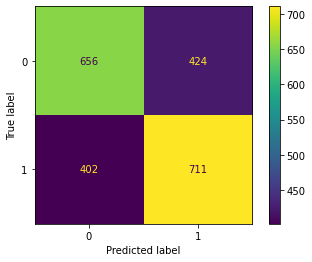

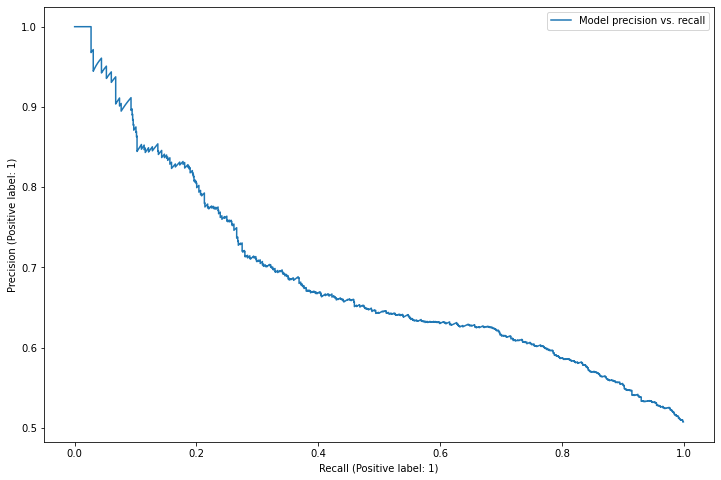

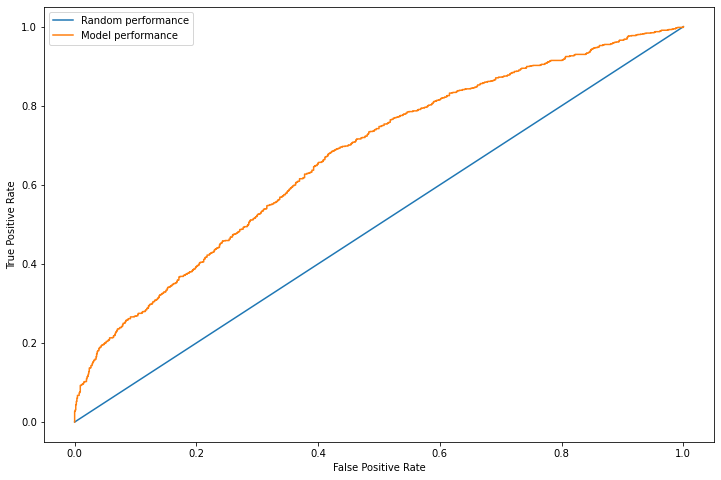

In [17]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [18]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-LSTM-undersampling' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-LSTM-undersampling20210527-0231


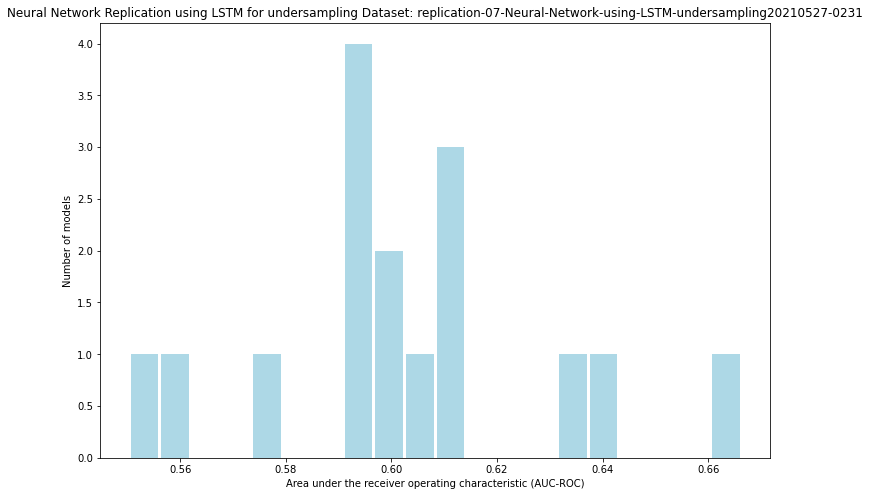

In [19]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using LSTM for undersampling Dataset: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)